In [8]:
import numpy as np
import torch
from math import sqrt
DATA_SIZE = 100
np.random.seed(seed=10)
train_data = np.random.rand(2,DATA_SIZE)
train_label = np.where(train_data[0] * train_data[1] < 0.25, -1, 1)
def Frax(n):
    axis = n / torch.norm(n)
    return n[0] * X + n[1] * Y + n[2] * Z
def amplitude_embedding(data1, data2): 
    ans = torch.tensor([data1,data2]).to(torch.complex64)
    return ans / torch.norm(ans)
X = torch.tensor([[0,1],[1,0]], dtype=torch.complex64)
Y = torch.tensor([[0,-1j],[1j,0]], dtype=torch.complex64)
Z = torch.tensor([[1,0],[0,-1]], dtype=torch.complex64)
XY = (X+Y)/sqrt(2)
XZ = (X+Z)/sqrt(2)
YZ = (Y+Z)/sqrt(2)
def lastbit_Z(state):
    return 2 * (torch.norm(state[0:len(state):2])**2) - 1
def predict(n1, n2):
    acc = 0
    score = 0
    for i in range(DATA_SIZE):
        data = amplitude_embedding(train_data[0,i], train_data[1,i])
        score += lastbit_Z(torch.mv(Frax(n2), torch.mv(Frax(n1), data))) * train_label[i]
        if lastbit_Z(torch.mv(Frax(n2), torch.mv(Frax(n1), data))) * train_label[i] > 0:
            acc += 1
    return acc / DATA_SIZE, score * 2

In [9]:
def optimize(which, n1, n2):
    R = torch.zeros((3,3))
    for i in range(DATA_SIZE):
        x = amplitude_embedding(train_data[0,i], train_data[1,i])
        if which == 'n1':
            rx = Frax(n2) @ X @ x
            ry = Frax(n2) @ Y @ x
            rz = Frax(n2) @ Z @ x
            rxy = Frax(n2) @ XY @ x
            rxz = Frax(n2) @ XZ @ x
            ryz = Frax(n2) @ YZ @ x
        else:
            rx = X @ Frax(n1) @ x
            ry = Y @ Frax(n1) @ x
            rz = Z @ Frax(n1) @ x
            rxy = XY @ Frax(n1) @ x
            rxz = XZ @ Frax(n1) @ x
            ryz = YZ @ Frax(n1) @ x
        rx = lastbit_Z(rx)
        ry = lastbit_Z(ry)
        rz = lastbit_Z(rz)
        rxy = lastbit_Z(rxy)
        rxz = lastbit_Z(rxz)
        ryz = lastbit_Z(ryz)
        R[0,0] += train_label[i] * (2 * rx)
        R[0,1] += train_label[i] * (2 * rxy - rx - ry)
        R[0,2] += train_label[i] * (2 * rxz - rx - rz)
        R[1,1] += train_label[i] * (2 * ry)
        R[1,2] += train_label[i] * (2 * ryz - ry - rz)
        R[2,2] += train_label[i] * (2 * rz)
    R[1,0] = R[0,1]
    R[2,0] = R[0,2]
    R[2,1] = R[1,2]
    #print(R)
    eigenvalues, eigenvectors = torch.linalg.eigh(R)
    return eigenvectors[:,torch.argmax(eigenvalues)], torch.max(eigenvalues)

In [11]:
n1 = (torch.zeros(3)+1/sqrt(3)).to(torch.complex64)
n2 = (torch.zeros(3)+1/sqrt(3)).to(torch.complex64)

acc = [predict(n1, n2)[0]]
las = [predict(n1, n2)[1]]

for i in range(25):
    n1, la1 = optimize('n1', n1, n2)
    acc.append(predict(n1, n2)[0])
    assert abs(predict(n1, n2)[1] - la1) < 1e-2, 'Error {0}, {1}'.format(predict(n1, n2)[1], la1)
    las.append(la1)
    n2, la2 = optimize('n2', n1, n2)
    acc.append(predict(n1, n2)[0])
    assert abs(predict(n1, n2)[1] - la2) < 1e-2, 'Error {0}, {1}'.format(predict(n1, n2)[1], la2)
    las.append(la2)

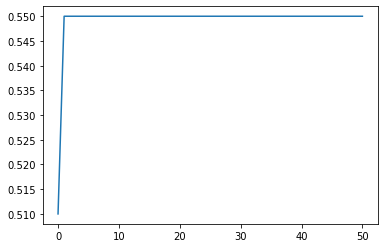

In [12]:
import matplotlib.pyplot as plt

plt.plot(acc)

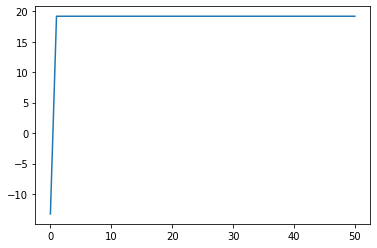

In [13]:
plt.plot(las)

In [14]:
las

[tensor(-13.2511),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716),
 tensor(19.1716)]